In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
from PIL import Image

In [2]:
labelled_json = json.load(open('./data/labeled_images.json', 'r'))
labelled_json[0]

{'image': 'frame_0655.jpg',
 'points': [{'x': 523, 'y': 348}, {'x': 548, 'y': 347}]}

In [20]:
def build_dataset(json_data):
    X, Y = [], []

    count = 0
    for item in json_data:
        count += 1
        img = Image.open('./data/raw_images/' + item['image'])
        img = img.resize((round(16/9 * 128), 128))
        img_tensor = torch.tensor(list(img.getdata()), dtype=torch.float32).view(3, 128, round(16/9 * 128))
        
        X.append(img_tensor)
        point_tensor = torch.tensor([item['points'][0]['x'], item['points'][0]['y'], item['points'][1]['x'], item['points'][1]['y']], dtype=torch.float32)
        Y.append(point_tensor)

        if count % 100 == 0:
            print(count)
    
    X = torch.stack(X)
    Y = torch.stack(Y)
    return X, Y


In [21]:
Xtr, Ytr = build_dataset(labelled_json[:int(len(labelled_json) * 0.8)])
print('loaded training data')
Xval, Yval = build_dataset(labelled_json[int(len(labelled_json) * 0.8):])
print('loaded validation data')

100
200
300
400
500
600
700
800
900
1000
1100
loaded training data
100
200
loaded validation data


In [5]:
X[0].shape

torch.Size([3, 128, 228])

In [33]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 57, 128)  # Adjust the input size based on your image dimensions
        self.relu3 = nn.ReLU()

        # Output layer
        self.fc2 = nn.Linear(128, 4)  # Output 4 logits

    def forward(self, x):
        # Input: (batch_size, channels, height, width)
        # Example: (batch_size, 3, 128, 228)

        # Convolutional layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)

        # Output layer
        x = self.fc2(x)

        return x

m = SimpleConvNet()

In [41]:
# get n parameters
n = sum(p.numel() for p in m.parameters())
print(n)

7476836


In [34]:
m = m.cuda()
Xtr, Ytr = Xtr.cuda(), Ytr.cuda()
Xval, Yval = Xval.cuda(), Yval.cuda()

In [35]:
# Define the loss function and optimizer
criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(m.parameters(), lr=3e-4)

In [36]:
lossi = []

In [37]:
def estimate_loss(split, batch_size=32):
    losses = []
    X = Xtr if split == 'train' else Xval
    Y = Ytr if split == 'train' else Yval
    m.eval()
    for i in range(0, len(split), batch_size):
        X_batch = X[i:i + batch_size]
        Y_batch = Y[i:i + batch_size]

        # Forward pass
        with torch.no_grad():
            Y_pred = m(X_batch)

        # Compute loss
        loss = criterion(Y_pred, Y_batch)

        losses.append(loss.item())

    m.train()
    return sum(losses) / len(losses)

In [38]:
# training loop
for i in range(100000):
    # zero the parameter gradients
    optimizer.zero_grad()

    idx = torch.randint(0, Xtr.shape[0], (32,))
    X = Xtr[idx]
    Y = Ytr[idx]

    # forward + backward + optimize
    outputs = m(X.float())
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()

    lossi.append(loss.item())

    # print statistics
    if i % 500 == 0:
        val_loss = estimate_loss('val')
        print(f"batch: {i}, train loss: {loss.item()}, val loss: {val_loss}")

batch: 0, train loss: 809232.625, val loss: 192689.875
batch: 500, train loss: 5949.31201171875, val loss: 31124.140625
batch: 1000, train loss: 3125.097900390625, val loss: 23263.552734375
batch: 1500, train loss: 1113.384521484375, val loss: 23472.640625
batch: 2000, train loss: 669.7945556640625, val loss: 23309.390625
batch: 2500, train loss: 184.92581176757812, val loss: 19563.10546875
batch: 3000, train loss: 104.52108001708984, val loss: 18383.0390625
batch: 3500, train loss: 244.3147735595703, val loss: 17487.39453125
batch: 4000, train loss: 268.9712219238281, val loss: 17715.56640625
batch: 4500, train loss: 122.7077407836914, val loss: 18089.419921875
batch: 5000, train loss: 290.5516052246094, val loss: 18498.6796875
batch: 5500, train loss: 33.09419250488281, val loss: 18460.244140625
batch: 6000, train loss: 124.6216049194336, val loss: 16794.228515625
batch: 6500, train loss: 583.3113403320312, val loss: 19929.71875
batch: 7000, train loss: 38.7477912902832, val loss: 17

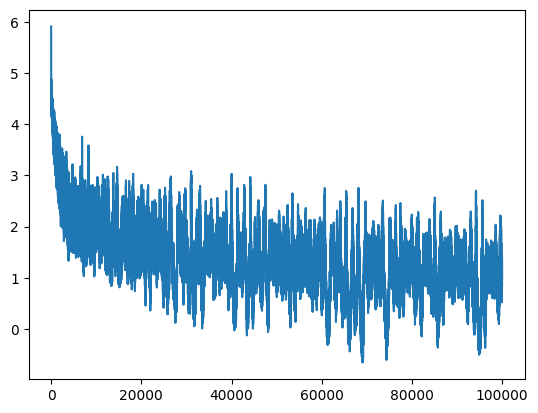

In [39]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(lossi).log10())

In [11]:
m(X[0].unsqueeze(0))

tensor([[523.8409, 348.0636, 548.8771, 347.0054]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [12]:

img = Image.open('./test.jpg')
img = img.resize((round(16/9 * 128), 128))
# img = img.resize((1920, 1080), resample=Image.BILINEAR)
img.save('./test_resized.jpg')
img_tensor = torch.tensor(list(img.getdata()), dtype=torch.float32).view(3, 128, round(16/9 * 128))


In [13]:
m(img_tensor.unsqueeze(0).cuda())

tensor([[648.5787, 844.9042, 659.7710, 829.2066]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [40]:
torch.save(m.state_dict(), './model.pt')